In [25]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import scipy as sc
import sympy as sp
#%matplotlib widget
import serial,socket,os,glob,sys
#import atexit
import numpy as np
import pandas as pd
import time, threading,sys,glob
from ipywidgets import interact, interact_manual,interactive,widgets,Layout
colores = (plt.rcParams['axes.prop_cycle'].by_key()['color'])
import tifffile as tif
import skimage as sk
from IPython.display import Latex
from funciones_wake import *
from scipy.signal import find_peaks
mks = ['s','o','>','p','v','^','*']




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


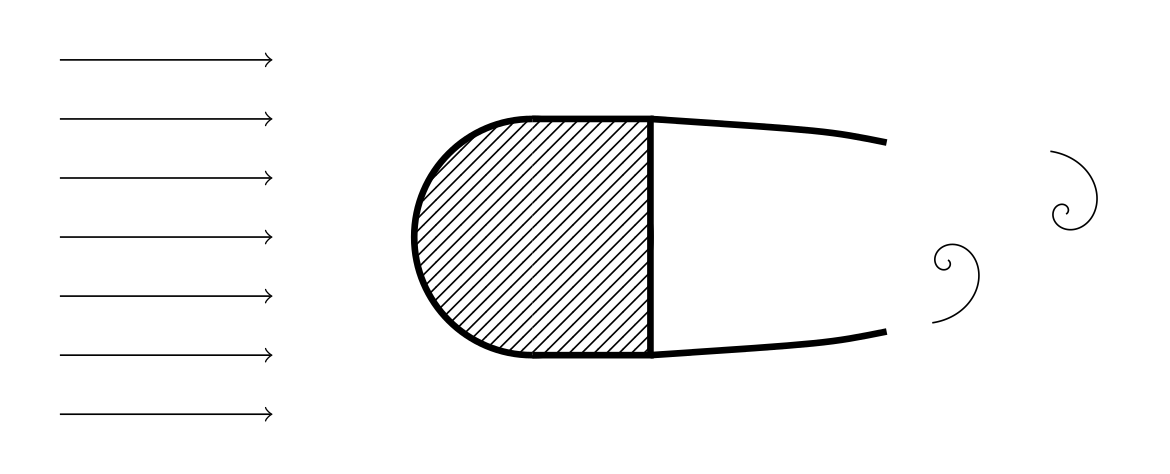

In [26]:
rho = 1.2
Lspan= 35e-2
D = 5e-2
Sf = Lspan*D
nu = 15e-6
scale_force = 1/241  # de gramo a newton  
g = 9.8
rho_50 = 1305
rho_75 = 1902
y1_50 = 37e-3
y1_75 = 50e-3
Largos  = np.array([0.75,1,1.25,1.5])
escala0 = 1/475  #px/

In [27]:
lista_soporte = np.sort(glob.glob('medidas/Dshape_soporte_V*'))
caso_soporte = caso_drag(lista_soporte)
lista_referencia = np.sort(glob.glob('medidas/Dshape_e00*'))
caso_referencia = caso_drag(lista_referencia)

casos_e50, casos_e75, casos_e50b,casos_e1000,casos_e1000_b=  [[],[],[],[],[]]
for Li in Largos:
    lista_e50 = np.sort(glob.glob(f'medidas/Dshape_e50_L{int(Li*100):03d}*'))
    lista_e75 = np.sort(glob.glob(f'medidas/Dshape_e75_L{int(Li*100):03d}*'))
    lista_e1000 = np.sort(glob.glob(f'medidas_ene_2025/Dshape_e1000_L{int(Li*100):03d}*'))
    lista_e1000_back = np.sort(glob.glob(f'medidas/Dshape_e1000_L{int(Li*100):03d}*'))
    lista_e50b = np.sort(glob.glob(f'medidas_ene_2025//Dshape_e50_L{int(Li*100):03d}*'))
    casos_e50.append(caso_drag(lista_e50))
    casos_e75.append(caso_drag(lista_e75))
    casos_e1000.append(caso_drag(lista_e1000))
    casos_e1000_b.append(caso_drag(lista_e1000_back))
    casos_e50b.append(caso_drag(lista_e50b))

# Fuerzas en el soporte

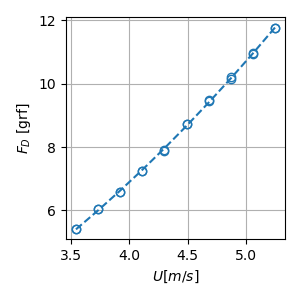

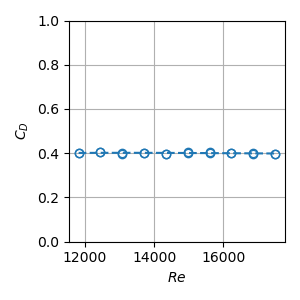

In [28]:
plt.close('all')
fig,ax = plt.subplots(figsize=(3,3))

FD_s = caso_soporte.df['FD_m'][caso_soporte.index_casos]
U_s = caso_soporte.df['velocity'][caso_soporte.index_casos]


p1_soporte = np.polyfit(U_s,FD_s,2)
F_soporte = np.poly1d(p1_soporte)
lin, = ax.plot(U_s,FD_s*1000/g,'o',fillstyle='none')
ax.plot(U_s,F_soporte(U_s)*1000/g,color=lin.get_color(),linestyle='--')
ax.set_xlabel('$U[m/s]$')
ax.set_ylabel('$F_D$ [grf]');
ax.grid()
fig.tight_layout()

fig1,ax1 = plt.subplots(figsize=(3,3))

lin1, = ax1.plot(U_s*D/nu,FD_s/(1/2*rho*Sf*U_s**2),'o',fillstyle='none')
ax1.plot(U_s*D/nu,F_soporte(U_s)/(1/2*rho*Sf*U_s**2),color=lin1.get_color(),linestyle='--')
ax1.set_xlabel('$Re$')
ax1.set_ylabel('$C_D$');
ax1.grid()
ax1.set_ylim([0,1])
fig1.tight_layout()




# Fuerzas cuerpo referencia

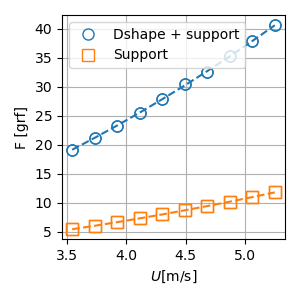

In [29]:
fig,ax = plt.subplots(figsize=(3,3))

FD_s_referencia = caso_referencia.df['FD_m'][caso_referencia.index_casos]
U_s_referencia = caso_referencia.df['velocity'][caso_referencia.index_casos]


p1_referencia = np.polyfit(U_s_referencia,FD_s_referencia,2)
F_referencia = np.poly1d(p1_referencia)

x,y,z = [[],[],[]]
for Ui in U_s_referencia:
        x.append(Ui)
        y.append(FD_s_referencia[U_s_referencia == Ui].mean())
        z.append(FD_s_referencia[U_s_referencia == Ui].std())
x = np.asarray(x)
y = np.asarray(y)
z = np.asarray(z)
lin0, = ax.plot(x,y*1000/g,'o',label='Dshape + support',fillstyle='none',markersize=8)
ax.plot(x,F_referencia(x)*1000/g,linestyle='--',color=lin0.get_color())
lin1, = ax.plot(x,F_soporte(x)*1000/g,'s',label = 'Support',fillstyle='none',markersize=8)
ax.plot(x,F_soporte(x)*1000/g,linestyle='--',color=lin1.get_color())
ax.grid()
ax.set_ylabel('F [grf]')
ax.set_xlabel('$U$[m/s]')
ax.legend();
fig.tight_layout()

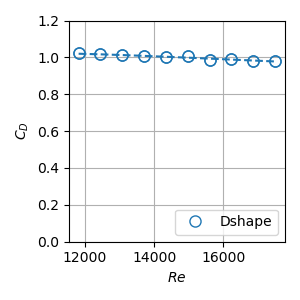

In [30]:
plt.close('all')
fig,ax = plt.subplots(figsize=(3,3))

FD_s_referencia = caso_referencia.df['FD_m'][caso_referencia.index_casos]
U_s_referencia = caso_referencia.df['velocity'][caso_referencia.index_casos]


p1_referencia = np.polyfit(U_s_referencia,FD_s_referencia,2)
F_referencia = np.poly1d(p1_referencia)

x,y,z = [[],[],[]]
for Ui in U_s_referencia:
        x.append(Ui)
        y.append(FD_s_referencia[U_s_referencia == Ui].mean() - F_soporte(Ui))
        z.append(FD_s_referencia[U_s_referencia == Ui].std())
x = np.asarray(x)
y = np.asarray(y)
z = np.asarray(z)
lin0, = ax.plot(x*D/nu,y /(1/2*rho*Sf*x**2),'o',label='Dshape',fillstyle='none',markersize=8)
ax.plot(x*D/nu,(F_referencia(x)-F_soporte(x))/(1/2*rho*Sf*x**2) ,linestyle='--',color=lin0.get_color())
ax.set_ylim([0,1.2])
ax.grid()
ax.set_ylabel('$C_D$')
ax.set_xlabel('$Re$')
ax.legend(loc='lower right');
fig.tight_layout()

# $C_D$ espesor 50 $\mu m$

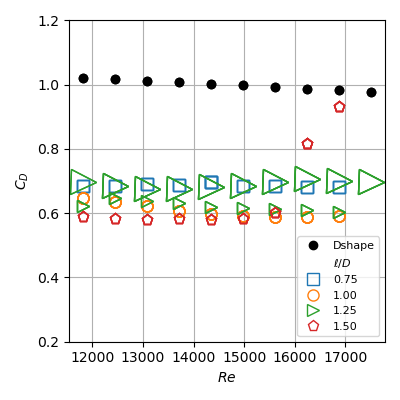

In [31]:
plt.close('all')
fig1,ax1 = plt.subplots(figsize=(4,4))
cd_ref = (F_referencia(U_s_referencia)-F_soporte(U_s_referencia))/(1/2*rho*U_s_referencia**2*Sf)

ax1.plot(U_s_referencia*D/nu,cd_ref,label = 'Dshape' 
         ,linestyle='none',
         fillstyle='full',color='k',marker = 'o',markersize=6)
ax1.plot([],[],linestyle='none',color='w', label='$\ell/D$')
for i, casoi in enumerate(casos_e50):
    FD_s = casoi.df['FD_m'][casoi.index_casos].to_numpy()
    U_s = casoi.df['velocity'][casoi.index_casos].to_numpy()
    x,y,z = [[],[],[]]
    for Ui in U_s:
        x.append(Ui)
        y.append(FD_s[U_s == Ui].mean()-F_soporte(Ui))
        z.append(FD_s[U_s == Ui].std())
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    lin1, = ax1.plot(x*D/nu,y/(1/2*rho*Sf*U_s**2),marker=mks[i],fillstyle='none',
                    linestyle='none',markersize=8,label = f'{Largos[i]:.2f}')
    if Largos[i]==1.25:
        casoi = casos_e50b[2]
        FD_s = casoi.df['FD_m'][casoi.index_casos].to_numpy()
        U_s = casoi.df['velocity'][casoi.index_casos].to_numpy()
        x,y,z = [[],[],[]]
        for Ui in U_s:
            x.append(Ui)
            y.append(FD_s[U_s == Ui].mean()-F_soporte(Ui))
            z.append(FD_s[U_s == Ui].std())
        x = np.asarray(x)
        y = np.asarray(y)
        z = np.asarray(z)
        
        lin2, = ax1.plot(x*D/nu,y/(1/2*rho*Sf*U_s**2),marker=mks[i],fillstyle='none',
                    linestyle='none',markersize=18,color=lin1.get_color())
    #ax1.plot(U_s*D/nu,F_soporte(U_s)/(1/2*rho*Sf*U_s**2),color=lin1.get_color(),linestyle='--')
ax1.set_xlabel('$Re$')
ax1.set_ylabel('$C_D$');
 
ax1.grid()
ax1.legend(ncols=1,fontsize=8,loc='lower right')
ax1.set_ylim([0.2,1.2])
fig1.tight_layout()


# $C_D$ espesor 75 $\mu m$

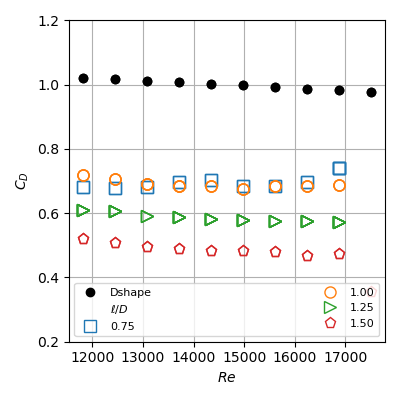

In [32]:
plt.close('all')
fig1,ax1 = plt.subplots(figsize=(4,4))
cd_ref = (F_referencia(U_s_referencia)-F_soporte(U_s_referencia))/(1/2*rho*U_s_referencia**2*Sf)

ax1.plot(U_s_referencia*D/nu,cd_ref,label = 'Dshape' 
         ,linestyle='none',
         fillstyle='full',color='k',marker = 'o',markersize=6)
ax1.plot([],[],linestyle='none',color='w', label='$\ell/D$')
for i, casoi in enumerate(casos_e75):
    FD_s = casoi.df['FD_m'][casoi.index_casos].to_numpy()
    U_s = casoi.df['velocity'][casoi.index_casos].to_numpy()
    x,y,z = [[],[],[]]
    for Ui in U_s:
        x.append(Ui)
        y.append(FD_s[U_s == Ui].mean()-F_soporte(Ui))
        z.append(FD_s[U_s == Ui].std())
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    lin1, = ax1.plot(x*D/nu,y/(1/2*rho*Sf*U_s**2),marker=mks[i],fillstyle='none',
                    linestyle='none',markersize=8,label = f'{Largos[i]:.2f}')
    #ax1.plot(U_s*D/nu,F_soporte(U_s)/(1/2*rho*Sf*U_s**2),color=lin1.get_color(),linestyle='--')
ax1.set_xlabel('$Re$')
ax1.set_ylabel('$C_D$');
ax1.legend(ncols=2,mode='expand',fontsize=8)
ax1.grid()
ax1.set_ylim([0.2,1.2])
fig1.tight_layout()
#ax1.legend(bbox_to_anchor=(1.15, 1), loc="upper left",fontsize=8,mode='expand')
#h, l = ax1.get_legend_handles_labels()
#ax1.legend(h, l, borderaxespad=0)


# $C_D$ rigidos

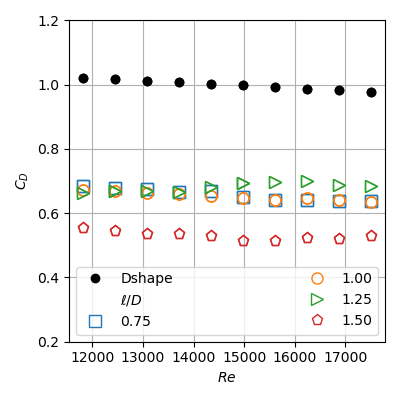

In [33]:
plt.close('all')
fig1,ax1 = plt.subplots(figsize=(4,4))
cd_ref = (F_referencia(U_s_referencia)-F_soporte(U_s_referencia))/(1/2*rho*U_s_referencia**2*Sf)

ax1.plot(U_s_referencia*D/nu,cd_ref,label = 'Dshape' 
         ,linestyle='none',
         fillstyle='full',color='k',marker = 'o',markersize=6)
ax1.plot([],[],linestyle='none',color='w', label='$\ell/D$')
for i, casoi in enumerate(casos_e1000):
    FD_s = casoi.df['FD_m'][casoi.index_casos].to_numpy()
    U_s = casoi.df['velocity'][casoi.index_casos].to_numpy()
    x,y,z = [[],[],[]]
    for Ui in U_s:
        x.append(Ui)
        y.append(FD_s[U_s == Ui].mean()-F_soporte(Ui))
        z.append(FD_s[U_s == Ui].std())
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    lin1, = ax1.plot(x*D/nu,y/(1/2*rho*Sf*U_s**2),marker=mks[i],fillstyle='none',
                    linestyle='none',markersize=8,label = f'{Largos[i]:.2f}')
    #ax1.plot(U_s*D/nu,F_soporte(U_s)/(1/2*rho*Sf*U_s**2),color=lin1.get_color(),linestyle='--')
ax1.set_xlabel('$Re$')
ax1.set_ylabel('$C_D$');
ax1.legend(ncols=2,mode='expand')
ax1.grid()
ax1.set_ylim([0.2,1.2])
fig1.tight_layout()
#ax1.legend(bbox_to_anchor=(1.15, 1), loc="upper left",fontsize=8,mode='expand')
#h, l = ax1.get_legend_handles_labels()
#ax1.legend(h, l, borderaxespad=0)


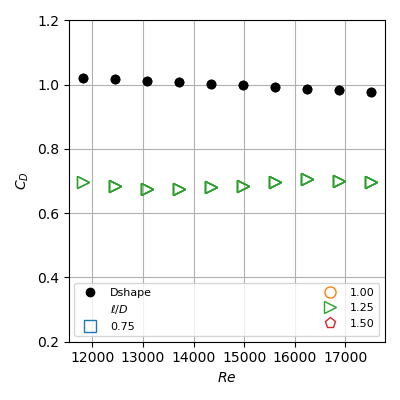

In [34]:
plt.close('all')
fig1,ax1 = plt.subplots(figsize=(4,4))
cd_ref = (F_referencia(U_s_referencia)-F_soporte(U_s_referencia))/(1/2*rho*U_s_referencia**2*Sf)

ax1.plot(U_s_referencia*D/nu,cd_ref,label = 'Dshape' 
         ,linestyle='none',
         fillstyle='full',color='k',marker = 'o',markersize=6)
ax1.plot([],[],linestyle='none',color='w', label='$\ell/D$')
for i, casoi in enumerate(casos_e50b):
    FD_s = casoi.df['FD_m'][casoi.index_casos].to_numpy()
    U_s = casoi.df['velocity'][casoi.index_casos].to_numpy()
    x,y,z = [[],[],[]]
    for Ui in U_s:
        x.append(Ui)
        y.append(FD_s[U_s == Ui].mean()-F_soporte(Ui))
        z.append(FD_s[U_s == Ui].std())
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    lin1, = ax1.plot(x*D/nu,y/(1/2*rho*Sf*U_s**2),marker=mks[i],fillstyle='none',
                    linestyle='none',markersize=8,label = f'{Largos[i]:.2f}')
    #ax1.plot(U_s*D/nu,F_soporte(U_s)/(1/2*rho*Sf*U_s**2),color=lin1.get_color(),linestyle='--')
ax1.set_xlabel('$Re$')
ax1.set_ylabel('$C_D$');
ax1.legend(ncols=2,mode='expand',fontsize=8)
ax1.grid()
ax1.set_ylim([0.2,1.2])
fig1.tight_layout()
#ax1.legend(bbox_to_anchor=(1.15, 1), loc="upper left",fontsize=8,mode='expand')
#h, l = ax1.get_legend_handles_labels()
#ax1.legend(h, l, borderaxespad=0)


# Análisis
### Se trata de control a partir de una cavidad en la base del cuerpo.Hay distintas referencias:
- FLOW MANAGEMENT TECHNIQUES FOR BASE AND AFTERBODY DRAG REDUCTION, P. R. Viswanath 1996 Fig 9 from Morel 1979
- Morel 1979
- Nash 1965 ya reportaba resultados sobre cavidades en la base. Cavidades perforadas (ver idea de la porosidad)

Aparece aumentos (L=100, L=125) respecto del valor 0.75

# medidas "fallidas" de Cd con flaps rigidos
## me faltó/se borró el caso para L=100
Las medidas restantes dan ligeramente por encima de las presentadas arriba.

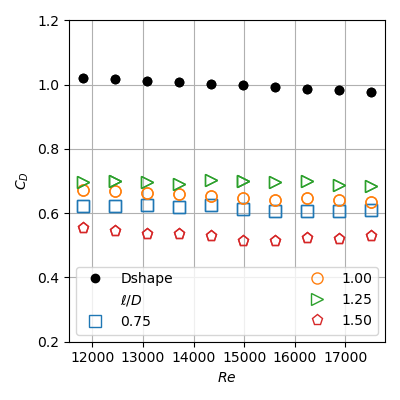

In [35]:

plt.close('all')
fig1,ax1 = plt.subplots(figsize=(4,4))
cd_ref = (F_referencia(U_s_referencia)-F_soporte(U_s_referencia))/(1/2*rho*U_s_referencia**2*Sf)

ax1.plot(U_s_referencia*D/nu,cd_ref,label = 'Dshape' 
         ,linestyle='none',
         fillstyle='full',color='k',marker = 'o',markersize=6)
ax1.plot([],[],linestyle='none',color='w', label='$\ell/D$')
for i, casoi in enumerate(casos_e1000_b):
    FD_s = casoi.df['FD_m'][casoi.index_casos].to_numpy()
    U_s = casoi.df['velocity'][casoi.index_casos].to_numpy()
    x,y,z = [[],[],[]]
    for Ui in U_s:
        x.append(Ui)
        y.append(FD_s[U_s == Ui].mean()-F_soporte(Ui))
        z.append(FD_s[U_s == Ui].std())
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    lin1, = ax1.plot(x*D/nu,y/(1/2*rho*Sf*U_s**2),marker=mks[i],fillstyle='none',
                    linestyle='none',markersize=8,label = f'{Largos[i]:.2f}')
    #ax1.plot(U_s*D/nu,F_soporte(U_s)/(1/2*rho*Sf*U_s**2),color=lin1.get_color(),linestyle='--')
ax1.set_xlabel('$Re$')
ax1.set_ylabel('$C_D$');
ax1.legend(ncols=2,mode='expand')
ax1.grid()
ax1.set_ylim([0.2,1.2])
fig1.tight_layout()
#ax1.legend(bbox_to_anchor=(1.15, 1), loc="upper left",fontsize=8,mode='expand')
#h, l = ax1.get_legend_handles_labels()
#ax1.legend(h, l, borderaxespad=0)



# Estudio de Strouhal

## valores determinados desde la frecuencia de la fuerza medida

## No aparecen cambios de $St$  notables con la inclusión de los flaps

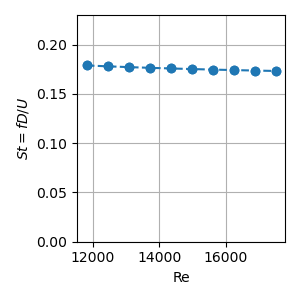

In [36]:
caso_referencia.freq_strouhal()
fr_strouhal_s = np.zeros_like(U_s_referencia)
for i,fr_st in enumerate(caso_referencia.strouhal_freq):
    fr_strouhal_s[i] = fr_st[0]
x,y= [[],[]]
for Ui in U_s:
    x.append(Ui)
    y.append(fr_strouhal_s[U_s == Ui].mean())
x,y = [np.asarray(x),np.asarray(y)]
p1 = np.polyfit(x,y,1)
f_strouhal = np.poly1d(p1)
fig,ax = plt.subplots(figsize=(3,3))
lin, = ax.plot(U_s_referencia*D/nu,y/U_s_referencia*D,'o')
ax.plot(U_s_referencia*D/nu,f_strouhal(U_s_referencia)*D/U_s_referencia,
        linestyle='dashed',color=lin.get_color())
ax.set_ylim([0,0.23]);
ax.grid()
ax.set_ylabel('$St = f D /U$')
ax.set_xlabel('Re');
fig.tight_layout()

# Strouhal espesor e50$\mu m$

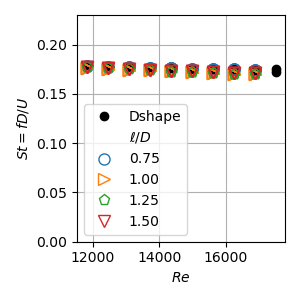

In [37]:

caso_referencia.freq_strouhal()
fr_strouhal_s = np.zeros_like(U_s_referencia)
for i,fr_st in enumerate(caso_referencia.strouhal_freq):
    fr_strouhal_s[i] = fr_st[0]
fig,ax = plt.subplots(figsize=(3,3))


ax.plot(U_s_referencia*D/nu,fr_strouhal_s/U_s_referencia*D,label = 'Dshape' 
         ,linestyle='none',
         fillstyle='full',color='k',marker = 'o',markersize=6)
ax.plot([],[],linestyle='none',color='w', label='$\ell/D$')


St_referencia = (fr_strouhal_s/U_s_referencia*D).mean()


for k,casoi in enumerate( casos_e50):
    casoi.freq_strouhal()
    U_si = casoi.df['velocity'][casoi.index_casos]
    fr_strouhal_s = np.zeros_like(U_si)
    for i,fr_st in enumerate(casoi.strouhal_freq):
        fr_strouhal_s[i] = fr_st[0]
    x,y= [[],[]]
    for Ui in U_si:
        x.append(Ui)
        y.append(fr_strouhal_s[U_si == Ui].mean())
    x,y = [np.asarray(x),np.asarray(y)]
    ax.plot(x*D/nu,y/U_si*D,marker=mks[k+1],fillstyle='none',
                    linestyle='none',markersize=8,label = f'{Largos[k]:.2f}')
    
ax.set_ylim([0,0.23]);
ax.grid()
ax.set_ylabel('$St = f D /U$')
ax.set_xlabel('$Re$');
ax.legend()
fig.tight_layout()

# Strouhal espesor e75$\mu m$

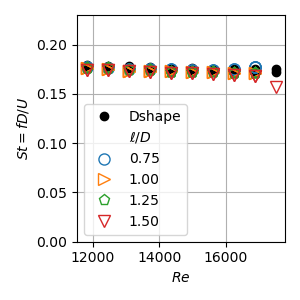

In [38]:
casos_plot = casos_e75
caso_referencia.freq_strouhal()
fr_strouhal_s = np.zeros_like(U_s_referencia)
for i,fr_st in enumerate(caso_referencia.strouhal_freq):
    fr_strouhal_s[i] = fr_st[0]
fig,ax = plt.subplots(figsize=(3,3))


ax.plot(U_s_referencia*D/nu,fr_strouhal_s/U_s_referencia*D,label = 'Dshape' 
         ,linestyle='none',
         fillstyle='full',color='k',marker = 'o',markersize=6)
ax.plot([],[],linestyle='none',color='w', label='$\ell/D$')


St_referencia = (fr_strouhal_s/U_s_referencia*D).mean()


for k,casoi in enumerate( casos_plot):
    casoi.freq_strouhal()
    U_si = casoi.df['velocity'][casoi.index_casos]
    fr_strouhal_s = np.zeros_like(U_si)
    for i,fr_st in enumerate(casoi.strouhal_freq):
        fr_strouhal_s[i] = fr_st[0]
    x,y= [[],[]]
    for Ui in U_si:
        x.append(Ui)
        y.append(fr_strouhal_s[U_si == Ui].mean())
    x,y = [np.asarray(x),np.asarray(y)]
    ax.plot(x*D/nu,y/U_si*D,marker=mks[k+1],fillstyle='none',
                    linestyle='none',markersize=8,label = f'{Largos[k]:.2f}')
    
ax.set_ylim([0,0.23]);
ax.grid()
ax.set_ylabel('$St = f D /U$')
ax.set_xlabel('$Re$');
ax.legend()
fig.tight_layout()

# Strouhal rigido

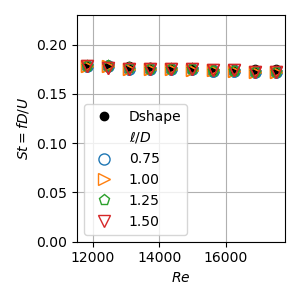

In [39]:
plt.close('all')
casos_plot = casos_e1000
caso_referencia.freq_strouhal()
fr_strouhal_s = np.zeros_like(U_s_referencia)
for i,fr_st in enumerate(caso_referencia.strouhal_freq):
    fr_strouhal_s[i] = fr_st[0]
fig,ax = plt.subplots(figsize=(3,3))


ax.plot(U_s_referencia*D/nu,fr_strouhal_s/U_s_referencia*D,label = 'Dshape' 
         ,linestyle='none',
         fillstyle='full',color='k',marker = 'o',markersize=6)
ax.plot([],[],linestyle='none',color='w', label='$\ell/D$')


St_referencia = (fr_strouhal_s/U_s_referencia*D).mean()


for k,casoi in enumerate( casos_plot):
    casoi.freq_strouhal()
    U_si = casoi.df['velocity'][casoi.index_casos]
    fr_strouhal_s = np.zeros_like(U_si)
    for i,fr_st in enumerate(casoi.strouhal_freq):
        fr_strouhal_s[i] = fr_st[0]
    x,y= [[],[]]
    for Ui in U_si:
        x.append(Ui)
        y.append(fr_strouhal_s[U_si == Ui].mean())
    x,y = [np.asarray(x),np.asarray(y)]
    ax.plot(x*D/nu,y/U_si*D,marker=mks[k+1],fillstyle='none',
                    linestyle='none',markersize=8,label = f'{Largos[k]:.2f}')
    
ax.set_ylim([0,0.23]);
ax.grid()
ax.set_ylabel('$St = f D /U$')
ax.set_xlabel('$Re$');
ax.legend()
fig.tight_layout()

# Desplazamientos

## datos de imágenes de cámara rápida

In [40]:

fsampling = 250
lista_cam = np.sort(glob.glob('/media/juan/JUAN_PMMH/LFD/photron/dshape*'))
lista_casos = np.array([s for s in lista_cam if "_v0_" not in s])

lista_write =  np.sort(glob.glob('/home/juan/Documents/script_python/2024_flapflexwake/fastcam_coords/*.csv'))


dirw = '/home/juan/Documents/script_python/2024_flapflexwake/fastcam_stats/'
lista_objs = np.sort(glob.glob(dirw+'*.pickle'))

In [41]:
lista_objs[:2]

array(['/home/juan/Documents/script_python/2024_flapflexwake/fastcam_stats/dshape_t050_L075_v40_0_20240828_121348.pickle',
       '/home/juan/Documents/script_python/2024_flapflexwake/fastcam_stats/dshape_t050_L075_v42_0_20240828_121042.pickle'],
      dtype='<U112')

In [42]:
t,L = [50,1]
vals_50 = []

lista_casos_t = np.array([s for s in lista_objs if f"t{int(t):03d}_" in s])
Largos  = np.array([0.75,1,1.25,1.5])
for j, L in enumerate(Largos):
    
    lista_casos_tL = np.array([s for s in lista_casos_t if f"L{int(L*100):03d}_" in s])
    data_obj_50 = get_dataframe(lista_objs,t,L) 
    for i,filei in enumerate(lista_casos_tL):
        file_aux = open(filei, 'rb')
        data = pickle.load(file_aux)
        #print(data.files[0])
        data.wakeflex()
        data.caso_drag()
        data.caso_drag_fft()
        data.caso_drag_strouhal()
        x = data.U
        y = data.FD.mean() - F_soporte(data.U)
        y = y /(1/2*rho*Sf*data.U**2)
        
        
        z = data.FD.std()
        
        data_obj_50.loc[i,'$C_D$'] = y
    vals_50.append((data_obj_50['$U_\inf$'].to_numpy()*D/nu,
                    data_obj_50['$C_D$'].to_numpy()))
        
    

In [43]:
t,L = [75,1]
vals_75 = []
lista_casos_t = np.array([s for s in lista_objs if f"t{int(t):03d}_" in s])
Largos  = np.array([0.75,1,1.25,1.5])
for j, L in enumerate(Largos):
    
    lista_casos_tL = np.array([s for s in lista_casos_t if f"L{int(L*100):03d}_" in s])
    data_obj_75 = get_dataframe(lista_objs,t,L) 
    for i,filei in enumerate(lista_casos_tL):
        file_aux = open(filei, 'rb')
        data = pickle.load(file_aux)
        #print(data.files[0])
        if filei == '/home/juan/Documents/script_python/2024_flapflexwake/fastcam_stats/dshape_t075_L150_v56_copia.pickle':
            data.volt = 56
            data.path = '/media/juan/JUAN_PMMH/LFD/photron/dshape_t075_L150_v56_copia.pickle'
        data.wakeflex()
        data.caso_drag()
        data.caso_drag_fft()
        data.caso_drag_strouhal()
        x = data.U
        y = data.FD.mean() - F_soporte(data.U)
        y = y /(1/2*rho*Sf*data.U**2)
        
        
        z = data.FD.std()
        data_obj_75.loc[i,'$U_\inf$'] = x
        data_obj_75.loc[i,'$C_D$'] = y
    vals_75.append((data_obj_75['$U_\inf$'].to_numpy()*D/nu,
                    data_obj_75['$C_D$'].to_numpy()))

In [39]:
data.U

5.060200000000001

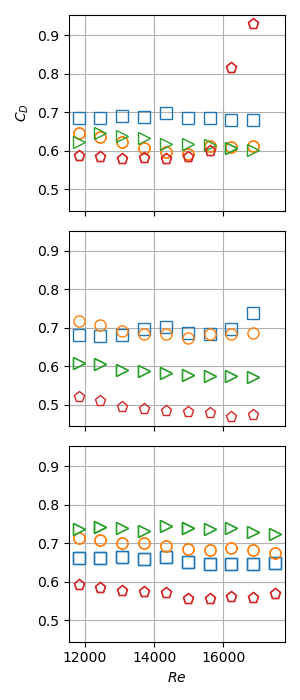

In [44]:
fig, ax = plt.subplots(3,1,sharey=True,figsize=(3,7),sharex=True)
ax0,ax1,ax2 = ax
for i,vali in enumerate(vals_50):
    ax0.plot(vali[0],vali[1],marker=mks[i],linestyle='none',markersize=8,fillstyle='none')
  
for i,vali in enumerate(vals_75):
    ax1.plot(vali[0],vali[1],marker=mks[i],linestyle='none',markersize=8,fillstyle='none')

for i, casoi in enumerate(casos_e1000_b):
    F_1000 = casoi.df['FD_m'][casoi.index_casos].to_numpy()
    U_1000 =  casoi.df['velocity'][casoi.index_casos].to_numpy()
    Fd_1000 = F_1000-F_soporte(U_1000)
    cd_1000 = Fd_1000 / (1/2*rho*U_1000**2*Sf)
    x,y = [[],[]]
    for Ui in U_1000:
        x.append(Ui*D/nu)
        y.append(cd_1000[U_1000 == Ui].mean()+0.04)
        
    ax2.plot(x,y,marker=mks[i],linestyle='none',markersize=8,fillstyle='none')
    
ax1.grid()
#ax1.set_ylim([0,1])
ax0.grid()
ax0.set_ylabel('$C_D$')
#ax0.set_xlabel('$Re$')
ax2.set_xlabel('$Re$')
ax2.grid()
fig.tight_layout()

In [73]:
t,L = [50,1]
vals_cd_delta_50 = []
vals_cd_deltarms_50 = []
vals_fn_fmax_50 = []
vals_Ur_Circ_Cy_50 = []

lista_casos_t = np.array([s for s in lista_objs if f"t{int(t):03d}_" in s])
Largos  = np.array([0.75,1,1.25,1.5])
for j, L in enumerate(Largos):   
    lista_casos_tL = np.array([s for s in lista_casos_t if f"L{int(L*100):03d}_" in s])
    data_obj_50 = get_dataframe(lista_objs,t,L) 
     
    xi = np.zeros((8,len(lista_casos_tL)))
    for i,filei in enumerate(lista_casos_tL):
        file_aux = open(filei, 'rb')
        data = pickle.load(file_aux)
        #print(data.files[0])
        data.wakeflex()
        data.caso_drag()
        data.caso_drag_fft()
        data.caso_drag_strouhal()
        #x = data.U
        theta = data.delta_0/data.Lr
        Circulacion = data.U*(D-data.delta_0*escala0*D*np.cos(theta))
        Fd = data.FD.mean() - F_soporte(data.U)
        cd = Fd /(1/2*rho*Sf*data.U**2)
        
        Ur = data.U / (data.freqn * data.Lr)
        xi[0,i]  = (D-data.delta_1*escala0*D)           
        xi[1,i] = cd 
        xi[2,i] = (D-data.delta_1_rms*escala0*D)
        xi[3,i] = data.freqn  
        xi[4,i] = np.min(data.frec_max1)
        xi[5,i] = Circulacion
        xi[6,i] = Ur
        xi[7,i] = data.U**2*rho/2*data.Lr**3/data.B/8
        data_obj_50.loc[i,'$C_D$'] = cd
    vals_cd_delta_50.append((xi[0],xi[1]))
    vals_cd_deltarms_50.append((xi[2],xi[1]))
    vals_fn_fmax_50.append((xi[3],xi[4]))
    vals_Ur_Circ_Cy_50.append((xi[6],xi[5],xi[7]))
        
    

In [74]:
t,L = [50,1]
vals_cd_delta_50b = []
vals_cd_deltarms_50b = []
vals_fn_fmax_50b = []
vals_Ur_Circ_Cy_50b = []
lista_objs_b = np.sort(glob.glob(dirw+'/back/*.pickle'))
lista_casos_t = np.copy(lista_objs_b)
Largos  = np.array([0.75,1,1.25,1.5])
for j, L in enumerate(Largos[:-1]):   
    lista_casos_tL = np.array([s for s in lista_casos_t if f"L{int(L*100):03d}_" in s])
    data_obj_50b = get_dataframe(lista_objs_b,t,L) 
    xi = np.zeros((8,len(lista_casos_tL)))
    for i,filei in enumerate(lista_casos_tL):
        file_aux = open(filei, 'rb')
        data = pickle.load(file_aux)
        #print(data.files[0])
        data.wakeflex()
        data.caso_drag()
        data.caso_drag_fft()
        data.caso_drag_strouhal()
        theta = data.delta_0/data.Lr
        

        
        Ur = data.U / (data.freqn * data.Lr)
        xi[0,i]  = (D-data.delta_1*escala0*D)           
        xi[1,i] = 0 
        xi[2,i] = (D-data.delta_1_rms*escala0*D)
        xi[3,i] = data.freqn  
        xi[4,i] = np.min(data.frec_max1)
        xi[5,i] = 0
        xi[6,i] = Ur
        xi[7,i] = data.U**2*rho/2*data.Lr**3/data.B/8
        data_obj_50.loc[i,'$C_D$'] = cd
    vals_cd_delta_50b.append((xi[0],xi[1]))
    vals_cd_deltarms_50b.append((xi[2],xi[1]))
    vals_fn_fmax_50b.append((xi[3],xi[4]))
    vals_Ur_Circ_Cy_50b.append((xi[6],xi[5],xi[7]))


In [75]:
t,L = [75,1]
vals_cd_delta_75 = []
vals_cd_deltarms_75 = []
vals_fn_fmax_75 = []
vals_Ur_Circ_Cy_75 = []

lista_casos_t = np.array([s for s in lista_objs if f"t{int(t):03d}_" in s])
Largos  = np.array([0.75,1,1.25,1.5])
for j, L in enumerate(Largos):   
    lista_casos_tL = np.array([s for s in lista_casos_t if f"L{int(L*100):03d}_" in s])
    data_obj_75 = get_dataframe(lista_objs,t,L) 
     
    xi = np.zeros((8,len(lista_casos_tL)))
    for i,filei in enumerate(lista_casos_tL):
        file_aux = open(filei, 'rb')
        data = pickle.load(file_aux)
        #print(data.files[0])
        data.wakeflex()
        data.caso_drag()
        data.caso_drag_fft()
        data.caso_drag_strouhal()
        #x = data.U
        theta = data.delta_0/data.Lr
        Circulacion = data.U*(D-data.delta_0*escala0*D*np.cos(theta))
        
        Fd = data.FD.mean() - F_soporte(data.U)
        cd = Fd /(1/2*rho*Sf*data.U**2)
        
        Ur = data.U / (data.freqn * data.Lr)
        xi[0,i]  = (D-data.delta_1*escala0*D)           
        xi[1,i] = cd 
        xi[2,i] = (D-data.delta_1_rms*escala0*D)
        xi[3,i] = data.freqn  
        xi[4,i] = np.min(data.frec_max1)
        xi[5,i] = Circulacion
        xi[6,i] = Ur
        xi[7,i] = data.U**2*rho/2*data.Lr**3/data.B/8
        
        data_obj_75.loc[i,'$C_D$'] = cd
    #print(xi[7])
    vals_cd_delta_75.append((xi[0],xi[1]))
    vals_cd_deltarms_75.append((xi[2],xi[1]))
    vals_fn_fmax_75.append((xi[3],xi[4]))
    vals_Ur_Circ_Cy_75.append((xi[6],xi[5],xi[7]))
        
    

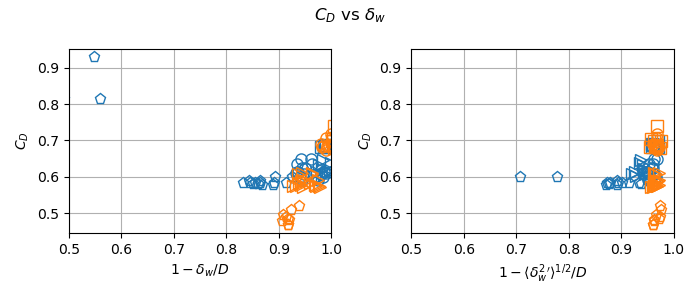

In [47]:
plt.close('all')
fig0, axs = plt.subplots(1,2,figsize=(7,3))
ax0,ax1 = axs
for i,vali in enumerate(vals_cd_delta_50):
    ax0.plot(vali[0]/D,vali[1],marker=mks[i],linestyle='none',markersize=8,fillstyle='none',color='tab:blue')
ax0.set_prop_cycle(None)
for i,vali in enumerate(vals_cd_delta_75):       
    ax0.plot(vali[0]/D,vali[1],marker=mks[i],linestyle='none',markersize=8,fillstyle='none',color='tab:orange')

for i,vali in enumerate(vals_cd_deltarms_50):       
    ax1.plot(vali[0]/D,vali[1],marker=mks[i],linestyle='none',markersize=8,fillstyle='none',color='tab:blue')
for i,vali in enumerate(vals_cd_deltarms_75):       
    ax1.plot(vali[0]/D,vali[1],marker=mks[i],linestyle='none',markersize=8,fillstyle='none',color='tab:orange')


for axi in axs:
    axi.set_ylabel('$C_D$')
    axi.set_xlim([0.5,1])
    axi.grid()
ax0.set_xlabel('$1-\delta_w/D$')    
ax1.set_xlabel(r'$1-\langle{\delta_w^2}^\prime\rangle^{1/2}/D$')    

fig0.suptitle('$C_D$ vs $\delta_w$')
fig0.tight_layout()

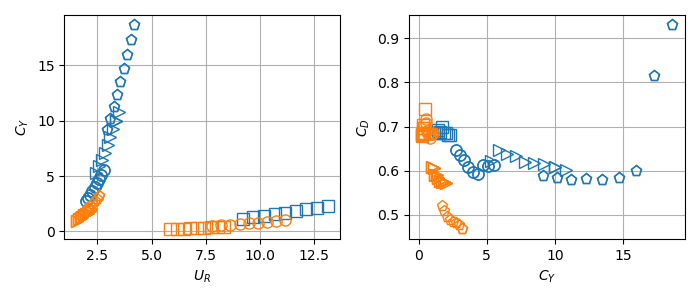

In [48]:
plt.close('all')
fig0, axs = plt.subplots(1,2,figsize=(7,3))
ax0,ax1 = axs
for i,vali in enumerate(vals_Ur_Circ_Cy_50):
    y = vals_cd_deltarms_50[i][1]
    x = vali[2]
    y = vali[0]
    ax0.plot(y,x,marker=mks[i],linestyle='none',markersize=8,fillstyle='none',color='tab:blue')
ax0.set_prop_cycle(None)

for i,vali in enumerate(vals_Ur_Circ_Cy_75):
    y = vals_cd_deltarms_75[i][1]
    x = vali[2]
    y = vali[0]
    ax0.plot(y,x,marker=mks[i],linestyle='none',markersize=8,fillstyle='none',color='tab:orange')
    
for i,vali in enumerate(vals_Ur_Circ_Cy_50):
    y = vals_cd_deltarms_50[i][1]
    x = vali[2]
    #y = vali[0]
    ax1.plot(x,y,marker=mks[i],linestyle='none',markersize=8,fillstyle='none',color='tab:blue')
ax1.set_prop_cycle(None)

for i,vali in enumerate(vals_Ur_Circ_Cy_75):
    y = vals_cd_deltarms_75[i][1]
    x = vali[2]
    #y = vali[0]
    ax1.plot(x,y,marker=mks[i],linestyle='none',markersize=8,fillstyle='none',color='tab:orange')
 



#for i,vali in enumerate(vals_Ur_Circ_Cy_75):       
#    ax0.plot(vali[0]/D,vali[1],marker=mks[i],linestyle='none',markersize=8,fillstyle='none',color='tab:orange')




ax0.set_ylabel('$C_Y$')
ax0.set_xlabel('$U_R$')
ax0.grid()
ax1.set_ylabel('$C_D$')
ax1.set_xlabel('$C_Y$')
ax1.grid() 
fig0.tight_layout()

### hay una diferencia en las dos curvas dada por la frecuencia natural seleccionada, distinto modo elástico

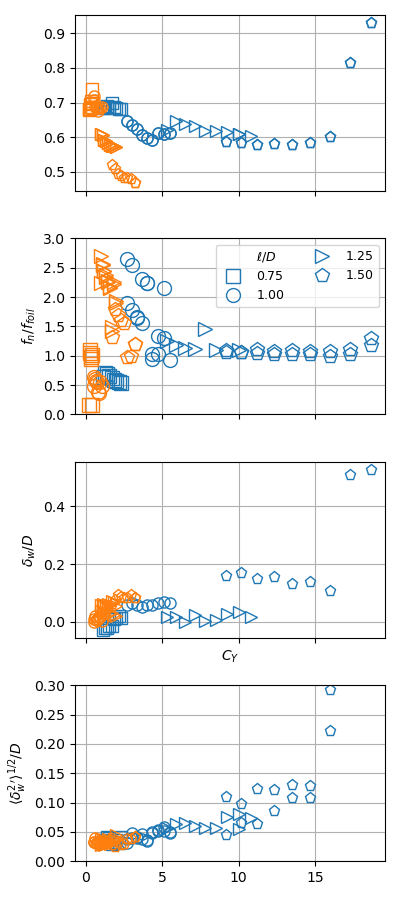

In [49]:
plt.close('all')
fig,axs = plt.subplots(4,1,figsize=(4,9),sharex = True)
ax1,ax0,ax3,ax2  = axs
ax0.plot([],[],label='$\ell/D$',linestyle='')
for i,vali in enumerate(vals_fn_fmax_50):
    
    y = vali[0]/vali[1]
    x = vals_Ur_Circ_Cy_50[i][2]
    ax0.plot(x,y,marker=mks[i],linestyle='none',markersize=10,fillstyle='none',color='tab:blue',
           label=f'${Largos[i]:.2f}$')
for i,vali in enumerate(vals_fn_fmax_75):
    y = vali[0]/vali[1]
    x = vals_Ur_Circ_Cy_75[i][2]
    ax0.plot(x,y,marker=mks[i],linestyle='none',markersize=10,fillstyle='none',color='tab:orange')

    
for i,vali in enumerate(vals_Ur_Circ_Cy_50):
    y = vals_cd_deltarms_50[i][1]
    x = vali[2]
    #y = vali[0]
    ax1.plot(x,y,marker=mks[i],linestyle='none',markersize=8,fillstyle='none',color='tab:blue')

    y1 = vals_cd_deltarms_50[i][0]
    y2 = vals_cd_delta_50[i][0]  
    if i>-1:
        ax2.plot(x,(-y1+D)/D,marker=mks[i],linestyle='none',markersize=8,fillstyle='none',color='tab:blue')
        xb = np.unique(x)
        yb = np.zeros_like(xb)
        for k,xbi in enumerate(xb):
            yb[k] = np.min(y2[x==xbi])
        #raise ValueError()
        ax3.plot(xb,(-yb+D)/D,marker=mks[i],linestyle='none',markersize=8,fillstyle='none',color='tab:blue') 
ax1.set_prop_cycle(None)
ax2.set_prop_cycle(None)

for i,vali in enumerate(vals_Ur_Circ_Cy_75):
    y = vals_cd_deltarms_75[i][1]
    x = vali[2]
    y1 = vals_cd_deltarms_75[i][0]
    y2 = vals_cd_delta_75[i][0]    
    
    ax1.plot(x,y,marker=mks[i],linestyle='none',markersize=8,fillstyle='none',color='tab:orange') 
    if i >0:
        ax2.plot(x,(-y1+D)/D,marker=mks[i],linestyle='none',markersize=8,fillstyle='none',color='tab:orange') 
        
        
        ax3.plot(x,(-y2+D)/D,marker=mks[i],linestyle='none',markersize=8,fillstyle='none',color='tab:orange') 
 
    
for axi in axs:
    axi.grid()
ax0.set_ylim([0,3])
ax0.legend(ncols=2,mode=None,fontsize=9)
ax3.set_xlabel('$C_Y$')
ax0.set_ylabel('$f_n / f_{foil}$');
ax2.set_ylabel(r'$\langle{\delta_w^2}^\prime\rangle^{1/2}/D $');
ax3.set_ylabel(r'$ \delta_w /D $');
ax2.set_ylim([0,0.3])
fig.tight_layout()

In [ ]:
y2

In [ ]:
xb

In [ ]:
x

# Dependencia de frecuencia de oscilacion

In [ ]:
Largos  = np.array([0.75,1,1.25,1.5])

vals_75 = []
vals_50 = []
for i, lis in enumerate(Largos[:]):
    ax = plt.gca()
    data_obj_50 = get_dataframe(lista_objs,50,lis)  
   
    dataplot =  (data_obj_50).copy()
    #get_dataframe(lista_objs,75,data.freqn1.25)
    x = dataplot['$\\delta_0$'].to_numpy()*escala0*D
    y = rho*(dataplot['$U_\inf$']**2/2*dataplot['Largo']**4/dataplot['B']/8).to_numpy()
    #y = x/y 
    #x = dataplot['$U_\inf$']
    vals_50.append((x,y))

    data_obj_75 = get_dataframe(lista_objs,75,lis)  
    dataplot =  (data_obj_75).copy()
    #get_dataframe(lista_objs,75,1.25)
    x = dataplot['$\\delta_0$'].to_numpy()*escala0*D
    y = rho*(dataplot['$U_\inf$']**2/2*dataplot['Largo']**4/dataplot['B']/8).to_numpy()
    #y = x/y 
    #x = dataplot['$U_\inf$']
    vals_75.append((x,y))


In [ ]:
Largos  = np.array([0.75,1,1.25,1.5])

vals_75 = []
vals_50 = []
for i, lis in enumerate(Largos[:]):
    ax = plt.gca()
    data_obj_50 = get_dataframe(lista_objs,50,lis)  
   
    dataplot =  (data_obj_50).copy()
    #get_dataframe(lista_objs,75,1.25)
    y = dataplot['$\\delta_1$'].to_numpy()*data.escala0/D
    x = (dataplot['$f_n$']**1/dataplot['$f_{\\max 1}$']**1).to_numpy()
    vals_50.append((x,y))

    data_obj_75 = get_dataframe(lista_objs,75,lis)  
    dataplot =  (data_obj_75).copy()
    #get_dataframe(lista_objs,75,1.25)
    y = dataplot['$\\delta_1$'].to_numpy()*data.escala0/D
    x = (dataplot['$f_n$']**1/dataplot['$f_{\\max 1}$']**1).to_numpy()
    vals_75.append((x,y))

In [ ]:
fig,ax = plt.subplots()
ax.plot([],[],label='$\ell/D$')
for i,vali in enumerate(vals_50):
    ax.plot(vali[0],vali[1],marker=mks[i],linestyle='none',markersize=10,fillstyle='none',color='tab:blue',
           label=f'${Largos[i]:.2f}$')
for i,vali in enumerate(vals_75):
    ax.plot(vali[0],vali[1],marker=mks[i],linestyle='none',markersize=10,fillstyle='none',color='tab:orange')
ax.grid()
ax.set_xlim([0,4])
ax.legend()
ax.set_xlabel('$f_n/f_\max$')
ax.set_ylabel('$\delta_1$');

In [ ]:
Largos  = np.array([0.75,1,1.25,1.5])

vals_75 = []
vals_50 = []
for i, lis in enumerate(Largos[:]):
    ax = plt.gca()
    data_obj_50 = get_dataframe(lista_objs,50,lis)    
    dataplot =  (data_obj_50).copy()
    y = dataplot['$\\delta_1$'].to_numpy()*data.escala0/D
    x = (dataplot['$f_{\\max 1}$']**1/(St_referencia*dataplot['$U_\\inf$']/D)).to_numpy()
    vals_50.append((x,y))

    data_obj_75 = get_dataframe(lista_objs,75,lis)  
    dataplot =  (data_obj_75).copy()
    y = dataplot['$\\delta_1$'].to_numpy()*data.escala0/D
    x = (dataplot['$f_{\\max 1}$']**1/(St_referencia*dataplot['$U_\\inf$']/D)).to_numpy()
    vals_75.append((x,y))

In [ ]:
fig,ax = plt.subplots()
ax.plot([],[],label='$\ell/D$')
for i,vali in enumerate(vals_50):
    ax.plot(vali[0],vali[1],marker=mks[i],linestyle='none',markersize=10,fillstyle='none',color='tab:blue',
           label=f'${Largos[i]:.2f}$')
for i,vali in enumerate(vals_75):
    ax.plot(vali[0],vali[1],marker=mks[i],linestyle='none',markersize=10,fillstyle='none',color='tab:orange')
ax.grid()
ax.set_xlim([0,4])
ax.legend()
ax.set_xlabel('$f_{foil}/f_{vs}$')
ax.set_ylabel('$\delta_w / D$');

In [ ]:
#frecuencias 

# Esquema del modelo y vórtices

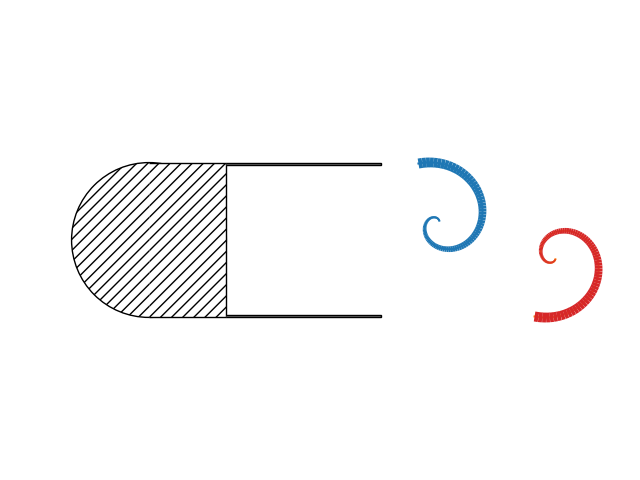

In [3]:
from matplotlib.patches import Rectangle, Circle, Polygon
from matplotlib.collections import LineCollection
fig,ax = plt.subplots()

                 
circle = Circle((0., 0), radius=4., edgecolor='black', facecolor='w',hatch='///')
 
ax.add_patch(circle)                
#ax.add_patch(rectangle) 
p1 = np.array([(0,4),(4,4),(4,-4),(0,-4)])
poly = Polygon(p1, edgecolor='black',closed=False,facecolor='w',hatch='///')
ax.add_patch (poly)
p2 = np.array([(4,3.9),(12,3.9),(12,4),(4,4)])
p3 = np.array([(4,-3.9),(12,-3.9),(12,-4),(4,-4)])
poly2 = Polygon(p2, edgecolor='black',closed=False,facecolor='gray')
poly3 = Polygon(p3, edgecolor='black',closed=False,facecolor='gray')
ax.add_patch (poly2)
ax.add_patch (poly3)
def vortex_im (xy,rot=0,orient=0,colorline='tab:orange'):
    theta = np.linspace(0,2*np.pi,100)
    r = theta*.5

    rot = rot+90

    zrot = r*np.exp(1j*theta) * np.exp(1j*rot*np.pi/180)



    x = np.real(zrot)+xy[0]
    y = np.imag(zrot)*(-1)**orient+xy[1] 
    lwidths = (1+theta)**1
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, linewidths=lwidths,color=colorline)
    return x,y,lc
    
x1,y1,lc1 = vortex_im((15,1),20,0,'tab:blue')
x2,y2,lc2 = vortex_im((21,-1),20,1,'tab:red')


from matplotlib.collections import LineCollection



ax.add_collection(lc1)
ax.plot(x1,y1)
ax.plot(x2,y2)
ax.add_collection(lc2)
ax.set_aspect('equal')
fig.tight_layout()
ax.axis('off');

In [ ]:
p1.shape